In [ ]:
"""
The purpose of this module is to create a dataset of doctor data that mimics what we might expect to find
among out client's databases. The content can then be used to trial analysis methods and generate example dashboard
outpts to showcase the kind of data analytics we can offer.
"""

In [2]:
import random as rn
import pandas as pd
from pandas import Series, DataFrame
from sklearn import tree

In [3]:
# dataframes / lookup tables

# Number of doctors in each state - input to assumption that all practices in any state have the same ratio
dfDrByState1 = pd.read_csv('DoctorsByState3.csv')
global dfDrByState1
dfDrByState2 = dfDrByState1.set_index('Place')
global dfDrByState2

# Insurance coverage in each state - input to assumption that all practices in any state have the same ratio
# https://www.kff.org/other/state-indicator/total-population
# determines what patient coverages are for practice based on state data
df2 = pd.read_csv('InsuranceCoverage2017v3.csv')
dfCoverageByState = df2.set_index('Location')
global dfCoverageByState

In [4]:
# Functions

# selector - made up shit: Doctor's age is indicative of how likely they are to prescribe Drug X
def DrAge():
    lower = 30
    upper= 70
    return rn.randint(lower,upper)

# selector - made up shit: Doctor's gender is indicative of how likely they are to prescribe Drug X
def DrGender():
    genderChoices = ['Male','Female']
    numGenderChoices = 1
    return rn.choices(genderChoices,k=numGenderChoices)[0]

# Journal of Medical Regulation Vol. 103 , No. 2 - A Census of Actively Licensed Physicians in the United States, 2016, Young et al
# this uses the number of doctors in state as a weighting for how likely the random doctor will be located in any particular US state
def DrLocationSelector():
#    doctorLocationChoices = dfDrByState2['Place']
    doctorLocationChoices = dfDrByState1['Place']
    doctorLocationFrequency = dfDrByState2['#Physicians']
    numLocationChoices = 1
    return rn.choices(doctorLocationChoices,weights=doctorLocationFrequency,k=numLocationChoices)[0] # choices returns a list

# selector - determines practice type basd on US national distribution
# https://www.ama-assn.org/about/research/physician-practice-benchmark-survey
def PracticeTypeSelector():
    practiceTypeChoices = ['Solo','Group - Single Specialty','Group - Multi-specialty','Employed Physician']
    practiceTypeFrequency = [16,47,28,9]
    numDrChoices = 1
    return rn.choices(practiceTypeChoices,weights=practiceTypeFrequency,k=numDrChoices)[0]

# selector - practice speciality
# Guesses and approximations have been used to set what practice types can have what specialties
# Guesses have been used to determine what ratio each specialty type appears in compared to the others
"""
Solo - Family, Internal, Orthopedic, General Surgery
Single Specialty - 'Emergency','Family','Internal','Orthopedic','Oncology', 'General Surgery', 'Endocrinology', 'Cardiology','Gastroenterology','Pulmonology', 'Ambulatory' 
Multi - Spec - 'Internal','Orthopedic','Oncology', 'General Surgery', 'Endocrinology', 'Cardiology','Gastroenterology','Pulmonology', 'Ambulatory'
Employed Phys - 'Emergency','Internal','Orthopedic','Oncology', 'General Surgery', 'Endocrinology', 'Cardiology','Gastroenterology','Pulmonology', 'Ambulatory'
"""
def PracticeSpecialtySelector(pracType):
    if pracType == 'Solo':
        selectFrom = ['Family', 'Internal', 'Orthopedic', 'General Surgery']
        selectFromWts = [35,25,20,20]
        
    elif pracType == 'Group - Single Specialty':
        selectFrom = ['Emergency','Family','Internal','Orthopedic','Oncology', 'General Surgery',
                      'Endocrinology', 'Cardiology','Gastroenterology','Pulmonology', 'Ambulatory']
        selectFromWts = [8,12,6,4,4,10,3,4,5,4,9]

    elif pracType == 'Group - Multi-specialty':
        selectFrom = ['Internal','Orthopedic','Oncology', 'General Surgery', 'Endocrinology',
                      'Cardiology','Gastroenterology','Pulmonology', 'Ambulatory']
        selectFromWts = [12,11,7,14,6,7,4,6,11]
        
    else: 
        selectFrom = ['Emergency','Internal','Orthopedic','Oncology', 'General Surgery', 'Endocrinology',
                      'Cardiology','Gastroenterology','Pulmonology', 'Ambulatory']
        selectFromWts = [11,10,9,3,14,5,9,7,7,10]
       
    specialtyChoice = rn.choices(selectFrom,weights=selectFromWts,k=1)[0]
    return specialtyChoice

# made-up shit: uses made-up (fictitious!!) factor based on practice type and doctor/patient ratio to determine # visitors
def PracticeSizeSelector(locn,pracType):
    typeFactor = {'Solo':1,'Group - Single Specialty':3,'Group - Multi-specialty':6,'Employed Physician':18}
    locFactor = dfDrByState2.loc[locn][2]
    return typeFactor[pracType] * locFactor

# https://www.kff.org/other/state-indicator/total-population
# determines what patient coverages are for practice based on state data
# returns medicaid%
def MedicaidCoverage(locn):
    return dfCoverageByState.loc[locn][2]

# https://www.kff.org/other/state-indicator/total-population
# determines what patient coverages are for practice based on state data
# returns medicare%
def MedicareCoverage(locn):
    return dfCoverageByState.loc[locn][3]

# selector - made up shit: how many medical society dinners a Dr attends is indicative of how likely they are to prescribe Drug X
def SocietyDinners():
    lower = 0
    upper= 5
    return rn.randint(lower,upper)

# selector - made up shit: how many CME events a Dr attends is indicative of how likely they are to prescribe Drug X
def ContinuingMedEd():
    lower = 0
    upper= 3
    return rn.randint(lower,upper)

# selector - made up shit: difference in how many prescriptions a Dr writes is a sucess measure for marketing Drug X
def ScriptsWritten():
    lower = 0
    upper= 50
    return rn.randint(lower,upper)

# selector - made up shit: how many times Dr visits web page is indicative of how likely they are to prescribe Drug X
def WebViews():
    lower = 0
    upper= 5
    return rn.randint(lower,upper)

# selector - made up shit: how many branded e-mails a Dr opens is indicative of how likely they are to prescribe Drug X
def BrandedEMopenRate():
    return rn.random()

# selector - made up shit: how many times Dr is contacted by Drug X rep is indicative of how likely they are to prescribe Drug X
def RepTouches():
    lower = 0
    upper= 1
    return rn.randint(lower,upper)

In [5]:
# dummy table value populator

# create empty lists/series for each variable
# start for (each Doctor) loop
# generate a value for each variable for 1 Doctor
# Do next Doctor
# merge lists to form Dataframe

numDoctors = 100

doctorAges = []
doctorGenders = []
doctorLocations = []
practiceTypes = []
practiceSpecialties = []
practiceSizes = []
practiceMedicaidCoverage = []
practiceMedicareCoverage = []
societyDinners = []
cmeCount = []
scriptCount = []
webViewCount = []
emailOpenRates = []
repTouchCounts = []

for dr in range(0,numDoctors):
    location = None
    practiceType = None
    practiceSize = 0
    
    doctorAges.append(DrAge())
    doctorGenders.append(DrGender())
    
    location = DrLocationSelector()
    doctorLocations.append(location)
    
    practiceType = PracticeTypeSelector()
    practiceTypes.append(practiceType)
    
    practiceSpecialty = PracticeSpecialtySelector(practiceType)
    practiceSpecialties.append(practiceSpecialty)
    
    practiceSize = PracticeSizeSelector(location,practiceType)
    practiceSizes.append(practiceSize)

    practiceMedicaidCoverage.append(MedicaidCoverage(location))
    practiceMedicareCoverage.append(MedicareCoverage(location))
    societyDinners.append(SocietyDinners())
    cmeCount.append(ContinuingMedEd())
    scriptCount.append(ScriptsWritten())
    webViewCount.append(WebViews())
    emailOpenRates.append(BrandedEMopenRate())
    repTouchCounts.append(RepTouches())

In [6]:
# make empty DF
dfDrDataSet1 = pd.DataFrame()

# populate empty DF with values from dummy generator
dfDrDataSet1['Age'] = doctorAges
dfDrDataSet1['Gender'] = doctorGenders
dfDrDataSet1['Location'] = doctorLocations
dfDrDataSet1['Prac Type'] = practiceTypes
dfDrDataSet1['Specialty'] = practiceSpecialties
dfDrDataSet1['Prac Size'] = practiceSizes
dfDrDataSet1['Medicaid'] = practiceMedicaidCoverage
dfDrDataSet1['Medicare'] = practiceMedicareCoverage
dfDrDataSet1['Soc Dinners'] = societyDinners
dfDrDataSet1['CMEs'] = cmeCount
dfDrDataSet1['Scripts'] = scriptCount
dfDrDataSet1['Web views'] = webViewCount
dfDrDataSet1['e-m opens'] = emailOpenRates
dfDrDataSet1['Rep touches'] = repTouchCounts

In [7]:
# Favourability Towards Drug X - Dr attractiveness score
# COPD - bias to old people (i.e. medicare good)
drugXAmenabilities = []

def DrugXAmenability(idx):
# Score Location element (medicaid -ve, medicare +ve)
    medicaidWeighting = 2
    medicaidScore = -float(medicaidWeighting*(dfDrDataSet1.iloc[idx]['Medicaid']-dfCoverageByState['Medicaid'].min())/
                           (dfCoverageByState['Medicaid'].max()-dfCoverageByState['Medicaid'].min()))

    medicareWeighting = 2
    medicareScore = float(medicareWeighting*(dfDrDataSet1.iloc[idx]['Medicare']-dfCoverageByState['Medicare'].min())/
                           (dfCoverageByState['Medicare'].max()-dfCoverageByState['Medicare'].min()))

# Score Pract Type (solo, employed bad; group good)
    pracTypeWeighting = 3
    if dfDrDataSet1.iloc[idx]['Prac Type'] == 'Solo':
        pracTypeScore = pracTypeWeighting*0
        
    elif dfDrDataSet1.iloc[idx]['Prac Type'] == 'Group - Single Specialty':
        pracTypeScore = pracTypeWeighting*1

    elif dfDrDataSet1.iloc[idx]['Prac Type'] == 'Group - Multi-specialty':
        pracTypeScore = pracTypeWeighting*1
        
    else:
        pracTypeScore = pracTypeWeighting*0
        
# Score Practice Size element (larger practices more attractive)
    pracSizeWeighting = 3
    if dfDrDataSet1.iloc[idx]['Prac Size'] >= 1000:
        pracSizeScore = pracSizeWeighting*1
        
    else:
        pracSizeScore = pracSizeWeighting*0

# Score SocDinner
    socDinnerWeighting = 2
    socDinnerScore = socDinnerWeighting*dfDrDataSet1.iloc[idx]['Soc Dinners']/5 # 5 is max SocDinners in this assumption

# Score CME
    cmeWeighting = 2
    cmeScore = cmeWeighting*dfDrDataSet1.iloc[idx]['CMEs']/3 # 3 is max CMEs in this assumption

# Score WebViews
    webViewWeighting = 2
    webViewWScore = webViewWeighting*dfDrDataSet1.iloc[idx]['Web views']/5 # 5 is max Web views in this assumption

# Score e-m open rate
    emOpenWeighting = 3
    if dfDrDataSet1.iloc[idx]['e-m opens'] >=0.4:
        emOpenScore = emOpenWeighting*dfDrDataSet1.iloc[idx]['e-m opens']
    else:
        emOpenScore = 0

# Score Specialty (only count Family, Internal, Pulm)
    if dfDrDataSet1.iloc[idx]['Specialty'] in ['Family','Internal','Pulmonology']:
        amenabilityScore = medicaidScore+medicareScore+pracTypeScore+pracSizeScore+socDinnerScore
        +cmeScore+webViewWScore+emOpenScore
    else:
        amenabilityScore = 0
    
    return float("{0:.2f}".format(amenabilityScore))

for i in range(numDoctors):
    drugXAmenabilities.append(DrugXAmenability(i))

In [8]:
dfDrDataSet2 = pd.DataFrame()
dfDrDataSet2['Age'] = doctorAges
dfDrDataSet2['Gender'] = doctorGenders
dfDrDataSet2['Location'] = doctorLocations
dfDrDataSet2['Prac Type'] = practiceTypes
dfDrDataSet2['Specialty'] = practiceSpecialties
dfDrDataSet2['Prac Size'] = practiceSizes
dfDrDataSet2['Medicaid'] = practiceMedicaidCoverage
dfDrDataSet2['Medicare'] = practiceMedicareCoverage
dfDrDataSet2['Soc Dinners'] = societyDinners
dfDrDataSet2['CMEs'] = cmeCount
dfDrDataSet2['Scripts'] = scriptCount
dfDrDataSet2['Web views'] = webViewCount
dfDrDataSet2['e-m opens'] = emailOpenRates
dfDrDataSet2['Rep touches'] = repTouchCounts
dfDrDataSet2['Amenablity to X'] = drugXAmenabilities

In [9]:
dfDrDataSet2.head(10)

,Age,Gender,Location,Prac Type,Specialty,Prac Size,Medicaid,Medicare,Soc Dinners,CMEs,Scripts,Web views,e-m opens,Rep touches,Amenablity to X
0,60,Male,FL,Group - Single Specialty,Family,1077,0.19,0.17,0,3,6,3,0.777666,1,7.33
1,42,Female,NY,Employed Physician,Gastroenterology,8568,0.26,0.12,3,3,45,2,0.124445,0,0.00
2,69,Female,CA,Group - Multi-specialty,Ambulatory,2280,0.26,0.11,3,2,50,5,0.394566,0,0.00
3,44,Female,WI,Solo,Internal,463,0.17,0.15,5,2,6,4,0.010582,1,3.00
4,49,Male,SD,Employed Physician,Internal,7920,0.14,0.14,4,1,21,4,0.290542,1,5.54
5,35,Male,MO,Group - Single Specialty,Orthopedic,1269,0.15,0.16,1,2,47,1,0.571034,1,0.00
6,65,Male,IL,Group - Single Specialty,Family,1161,0.20,0.13,5,3,10,4,0.454320,1,8.39
7,48,Male,RI,Group - Multi-specialty,Oncology,3084,0.24,0.14,0,0,5,4,0.106542,0,0.00
8,53,Female,GA,Group - Single Specialty,Internal,1047,0.17,0.12,4,0,8,4,0.293533,0,7.93
9,33,Female,KY,Group - Single Specialty,Emergency,1254,0.27,0.15,2,0,8,5,0.700424,0,0.00


In [10]:
# Will dr prescribe Drug X?
# COPD - bias to old people

prescribedDrugX = []
# weighted random choice, weighted towards yes by Soc Dinners, CME's, Scripts, webViews, e-mOpenRate, RepTouches
def PrescribesDrugX(idx):
# Score SocDinner
    socDinnerScore = dfDrDataSet1.iloc[idx]['Soc Dinners']/5 # 5 is max SocDinners in this assumption

# Score CME
    cmeScore = dfDrDataSet1.iloc[idx]['CMEs']/3 # 3 is max CMEs in this assumption
    
# Score Scripts
    scriptScore = dfDrDataSet1.iloc[idx]['Scripts']/50

# Score WebViews
    webViewWScore = dfDrDataSet1.iloc[idx]['Web views']/5 # 5 is max Web views in this assumption

# Score e-m open rate
    emOpenScore = dfDrDataSet1.iloc[idx]['e-m opens']

# Score repTouches - 50 - 85% chance of prescribing if repTouched
    if dfDrDataSet1.iloc[idx]['Rep touches'] >=0:
        repTouchScore = rn.randrange(50, 85, 1)
    else:
        repTouchScore = rn.randrange(0, 25, 1)
    repTouchScore = float(repTouchScore)/100
    
# Score Specialty (only count Family, Internal, Pulm)
    if dfDrDataSet1.iloc[idx]['Specialty'] in ['Family','Internal','Pulmonology']:
        prescribabilityScore = socDinnerScore+cmeScore+webViewWScore+emOpenScore+repTouchScore
        
    else:
        prescribabilityScore = 0
    
    population = [1,0]
    wghtg = [prescribabilityScore/7,(1-prescribabilityScore/7)]
    return rn.choices(population,weights=wghtg, k=1)[0]

for i in range(numDoctors):
    prescribedDrugX.append(PrescribesDrugX(i))

In [11]:
dfDrDataSet3 = pd.DataFrame()
dfDrDataSet3['Age'] = doctorAges
dfDrDataSet3['Gender'] = doctorGenders
dfDrDataSet3['Location'] = doctorLocations
dfDrDataSet3['Prac Type'] = practiceTypes
dfDrDataSet3['Specialty'] = practiceSpecialties
dfDrDataSet3['Prac Size'] = practiceSizes
dfDrDataSet3['Medicaid'] = practiceMedicaidCoverage
dfDrDataSet3['Medicare'] = practiceMedicareCoverage
dfDrDataSet3['Soc Dinners'] = societyDinners
dfDrDataSet3['CMEs'] = cmeCount
dfDrDataSet3['Scripts'] = scriptCount
dfDrDataSet3['Web views'] = webViewCount
dfDrDataSet3['e-m opens'] = emailOpenRates
dfDrDataSet3['Rep touches'] = repTouchCounts
dfDrDataSet3['Prescribed Drug X'] = prescribedDrugX

In [12]:
dfDrDataSet3.head(10)

,Age,Gender,Location,Prac Type,Specialty,Prac Size,Medicaid,Medicare,Soc Dinners,CMEs,Scripts,Web views,e-m opens,Rep touches,Prescribed Drug X
0,60,Male,FL,Group - Single Specialty,Family,1077,0.19,0.17,0,3,6,3,0.777666,1,0
1,42,Female,NY,Employed Physician,Gastroenterology,8568,0.26,0.12,3,3,45,2,0.124445,0,0
2,69,Female,CA,Group - Multi-specialty,Ambulatory,2280,0.26,0.11,3,2,50,5,0.394566,0,0
3,44,Female,WI,Solo,Internal,463,0.17,0.15,5,2,6,4,0.010582,1,1
4,49,Male,SD,Employed Physician,Internal,7920,0.14,0.14,4,1,21,4,0.290542,1,1
5,35,Male,MO,Group - Single Specialty,Orthopedic,1269,0.15,0.16,1,2,47,1,0.571034,1,0
6,65,Male,IL,Group - Single Specialty,Family,1161,0.20,0.13,5,3,10,4,0.454320,1,1
7,48,Male,RI,Group - Multi-specialty,Oncology,3084,0.24,0.14,0,0,5,4,0.106542,0,0
8,53,Female,GA,Group - Single Specialty,Internal,1047,0.17,0.12,4,0,8,4,0.293533,0,0
9,33,Female,KY,Group - Single Specialty,Emergency,1254,0.27,0.15,2,0,8,5,0.700424,0,0


In [13]:
# need to tokenise string variables
# and put in new DF

In [14]:
dfDrDataSet4 = dfDrDataSet3

In [15]:
#tokenise gender
dGender = {'Female': 0, 'Male': 1}
dfDrDataSet4['Gender'] = dfDrDataSet4['Gender'].map(dGender)

# tokenise location
df = pd.read_csv('DoctorsByState3.csv')
keys1 = df['Place']
values1 = range(1,len(df)+1)

tokenizedLoc = dict(zip(keys1,values1))
dfDrDataSet4['Location'] = dfDrDataSet4['Location'].map(tokenizedLoc)

# tokenise practice type
keys2 = ['Solo','Group - Single Specialty','Group - Multi-specialty','Employed Physician']
values2 = range(len(keys2))

tokenizedPracType = dict(zip(keys2,values2))
dfDrDataSet4['Prac Type'] = dfDrDataSet4['Prac Type'].map(tokenizedPracType)

#tokenise Specialty
unsorted = ['Family', 'Internal', 'Orthopedic', 'General Surgery','Emergency','Family','Internal','Orthopedic',
            'Oncology', 'General Surgery', 'Endocrinology', 'Cardiology','Gastroenterology','Pulmonology',
            'Ambulatory','Internal','Orthopedic','Oncology', 'General Surgery', 'Endocrinology', 'Cardiology',
            'Gastroenterology','Pulmonology', 'Ambulatory','Emergency','Internal','Orthopedic','Oncology',
            'General Surgery', 'Endocrinology', 'Cardiology','Gastroenterology','Pulmonology', 'Ambulatory']
keys3 = list(set(unsorted))
values3 = range(1,len(keys3)+1)
tokenizedSpecialty = dict(zip(keys3,values3))
dfDrDataSet4['Specialty'] = dfDrDataSet4['Specialty'].map(tokenizedSpecialty)

In [16]:
dfDrDataSet4.head()

,Age,Gender,Location,Prac Type,Specialty,Prac Size,Medicaid,Medicare,Soc Dinners,CMEs,Scripts,Web views,e-m opens,Rep touches,Prescribed Drug X
0,60,1,9,1,5,1077,0.19,0.17,0,3,6,3,0.777666,1,0
1,42,0,32,3,3,8568,0.26,0.12,3,3,45,2,0.124445,0,0
2,69,0,5,2,8,2280,0.26,0.11,3,2,50,5,0.394566,0,0
3,44,0,49,0,10,463,0.17,0.15,5,2,6,4,0.010582,1,1
4,49,1,41,3,10,7920,0.14,0.14,4,1,21,4,0.290542,1,1


In [17]:
dfDrDataSet4.shape[1]

15

In [18]:
"""
Next we need to separate the features from the target column that we're trying to bulid a decision tree for.
"""

features = list(dfDrDataSet4.columns[:14])
features

['Age',
 'Gender',
 'Location',
 'Prac Type',
 'Specialty',
 'Prac Size',
 'Medicaid',
 'Medicare',
 'Soc Dinners',
 'CMEs',
 'Scripts',
 'Web views',
 'e-m opens',
 'Rep touches']

In [19]:
# Now construct the decision tree:

y = dfDrDataSet4['Prescribed Drug X']
X = dfDrDataSet4[features]
clf_dTree = tree.DecisionTreeClassifier()
clf_dTree = clf_dTree.fit(X,y)

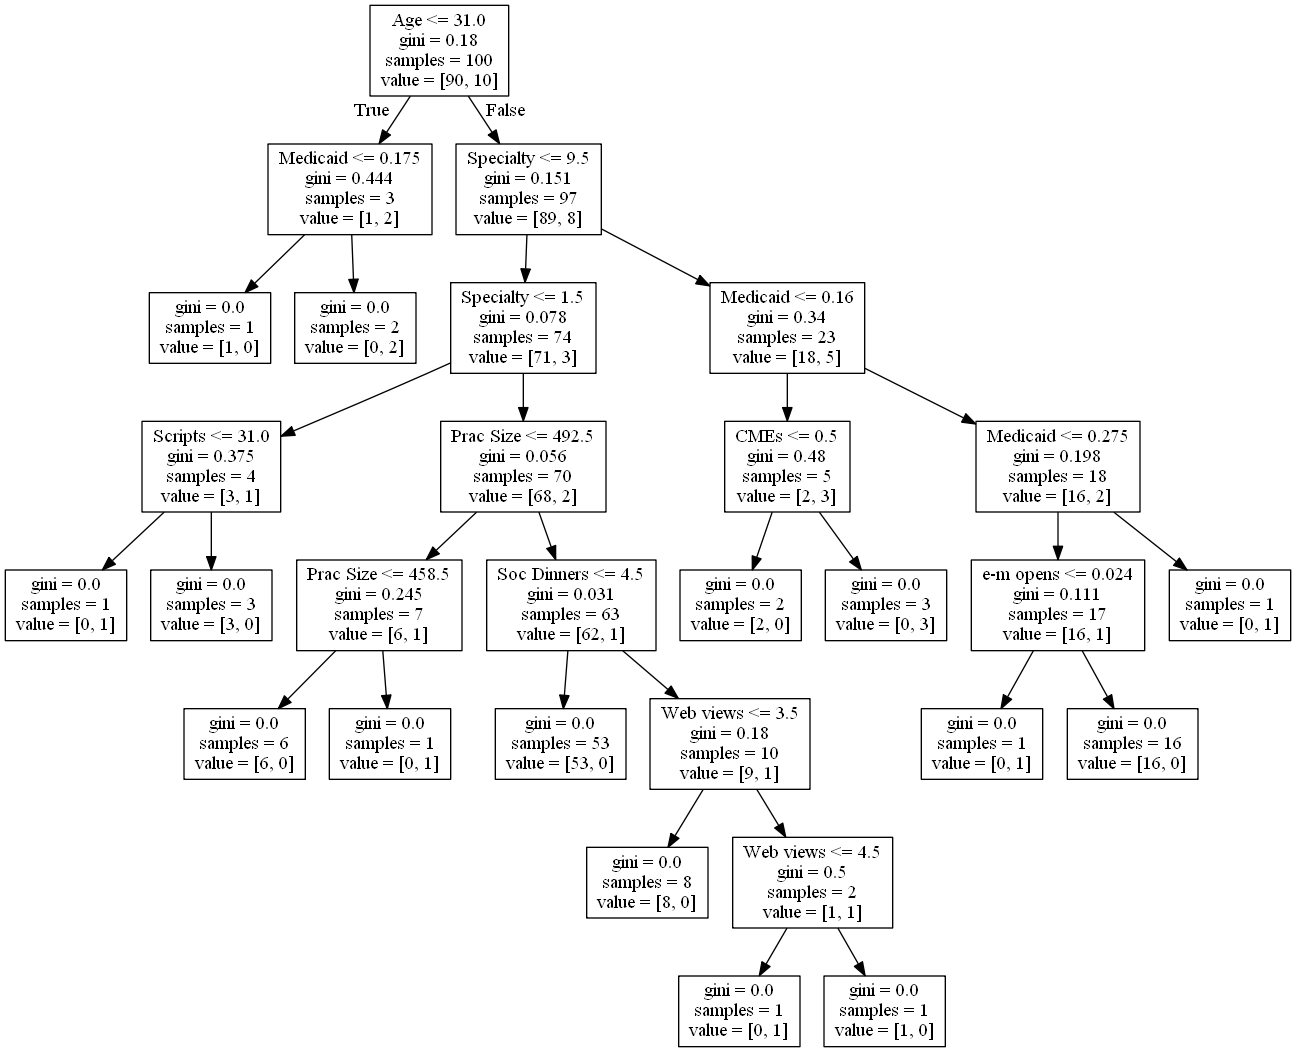

In [20]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
import pydotplus

dot_data = StringIO()  
tree.export_graphviz(clf_dTree, out_file=dot_data,  
                         feature_names=features)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [21]:
graph.write_png("DecisionTree.png")

True

In [22]:
dfDrDataSet4

,Age,Gender,Location,Prac Type,Specialty,Prac Size,Medicaid,Medicare,Soc Dinners,CMEs,Scripts,Web views,e-m opens,Rep touches,Prescribed Drug X
0,60,1,9,1,5,1077,0.19,0.17,0,3,6,3,0.777666,1,0
1,42,0,32,3,3,8568,0.26,0.12,3,3,45,2,0.124445,0,0
2,69,0,5,2,8,2280,0.26,0.11,3,2,50,5,0.394566,0,0
3,44,0,49,0,10,463,0.17,0.15,5,2,6,4,0.010582,1,1
4,49,1,41,3,10,7920,0.14,0.14,4,1,21,4,0.290542,1,1
5,35,1,25,1,2,1269,0.15,0.16,1,2,47,1,0.571034,1,0
6,65,1,13,1,5,1161,0.20,0.13,5,3,10,4,0.454320,1,1
7,48,1,39,2,7,3084,0.24,0.14,0,0,5,4,0.106542,0,0
8,53,0,10,1,10,1047,0.17,0.12,4,0,8,4,0.293533,0,0
9,33,0,17,1,4,1254,0.27,0.15,2,0,8,5,0.700424,0,0


In [23]:
dfDrDataSet4['Prescribed Drug X'].sum()

10

In [24]:
dfDrDataSet2.to_csv('Amenability to DrugX.csv')
dfDrDataSet3.to_csv('Prescribed DrugX.csv')